# Multivariate Stock Price Prediction

###Method: 
Predicting next day's 'Open' feature value of stock price by providing previous day's 4 main stock features i.e. ('Open', 'Close', 'High', 'Low') 

## Dataset:
Training in Google's 4 years of data.       
Dataset: https://www.kaggle.com/ptheru/googledta

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

In [ ]:
train_df = pd.read_csv('/content/trainset.csv')
test_df = pd.read_csv('/content/testset.csv')

In [ ]:
train_df = train_df.drop(['Adj Close', 'Volume', 'Date'], axis='columns') 
test_df = test_df.drop(['Adj Close', 'Volume', 'Date'], axis='columns') 

In [ ]:
train_df = train_df/1000  #scaling values
train_df.head()

,Open,High,Low,Close
0,0.357386,0.361151,0.355960,0.359288
1,0.360123,0.363600,0.358031,0.359497
2,0.362314,0.368339,0.361489,0.366601
3,0.365349,0.367301,0.362930,0.365001
4,0.365393,0.365771,0.359874,0.364281


In [ ]:
test_df = test_df/1000
test_df.head()

,Open,High,Low,Close
0,1.04834,1.06694,1.045230,1.06500
1,1.06431,1.08629,1.063210,1.08248
2,1.08800,1.09357,1.084002,1.08640
3,1.09400,1.10425,1.092000,1.10223
4,1.10223,1.11127,1.101620,1.10694


In [ ]:
len(train_df.index)

1259

In [ ]:
new_open = []
new_open2 = []

for i in range(len(train_df.index) - 1):
    new_open.append(train_df.loc[i+1,'Open'])


for i in range(len(test_df.index) - 1):
    new_open2.append(test_df.loc[i+1, 'Open'])


In [ ]:
new_open.append(0)
new_open2.append(0)

In [ ]:

train_df['new_open'] = new_open
test_df['new_open']  = new_open2

In [ ]:
train_df.head(), test_df.head()

(       Open      High       Low     Close  new_open
 0  0.357386  0.361151  0.355960  0.359288  0.360123
 1  0.360123  0.363600  0.358031  0.359497  0.362314
 2  0.362314  0.368339  0.361489  0.366601  0.365349
 3  0.365349  0.367301  0.362930  0.365001  0.365393
 4  0.365393  0.365771  0.359874  0.364281  0.363769,
       Open     High       Low    Close  new_open
 0  1.04834  1.06694  1.045230  1.06500   1.06431
 1  1.06431  1.08629  1.063210  1.08248   1.08800
 2  1.08800  1.09357  1.084002  1.08640   1.09400
 3  1.09400  1.10425  1.092000  1.10223   1.10223
 4  1.10223  1.11127  1.101620  1.10694   1.10940)

In [ ]:
train_df = train_df.drop(index=(len(train_df)-1), axis='rows')
test_df = test_df.drop(index=(len(test_df)-1), axis='rows')

In [ ]:
# test_df.head()

In [ ]:
# Concatenating train and test data into one dataframe
# used later for visualization part

total_df = pd.concat((train_df, test_df), axis='rows')
total_df.count(axis='rows')

Open        1382
High        1382
Low         1382
Close       1382
new_open    1382
dtype: int64

In [ ]:
# Splitting

X_train,Y_train = train_df.loc[:, ['Open','High','Low','Close']], train_df.loc[:, 'new_open']
X_test,Y_test = test_df.loc[:, ['Open','High','Low','Close']], test_df.loc[:, 'new_open']

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1258, 4) (1258,)
(124, 4) (124,)


In [ ]:
X_train, Y_train = X_train.to_numpy(), Y_train.to_numpy()
X_test, Y_test = X_test.to_numpy(), Y_test.to_numpy()

In [ ]:
type(X_train), type(Y_test), type(X_test), type(Y_train)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [ ]:
# Reshaping samples because LSTM layer requires 3d input
# New shape format: (samples, time_steps, features)   //time_steps=1, because we're prediciing next day's data

X_train = np.reshape(X_train, newshape=(X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, newshape=(X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_test.shape

## Model  Training

In [ ]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout

In [ ]:
model = Sequential()
model.add(LSTM(4,return_sequences=False,  batch_input_shape=(None, X_train.shape[1], X_train.shape[2] )))
# model.add(Dropout(0.2))
# model.add(LSTM(4, return_sequences=False))
model.add(Dense(1))

model.compile(loss='mse', optimizer= 'adam', metrics=['mse'])
model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 4)                 144       
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 5         
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss',patience=15)
callback = [es]

history = model.fit(X_train, Y_train, epochs=250, verbose=1,
                    validation_data=(X_test, Y_test), callbacks=callback ) 

# To fit without early stopping remove 'callbacks' parameter                    

## Evaluating Performance

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

pred = model.predict(X_test)

# Inverse scaling the values (working on original values)
pred = pred*1000
Y_test2 = Y_test*1000
Y_train = Y_train*1000
total_df = total_df*1000

Y_test2 = np.reshape(Y_test2, (Y_test2.shape[0], 1))

print('mse: ',mean_squared_error(pred, Y_test2))
print('rmse: ',sqrt(mean_squared_error(pred, Y_test2)))
print('mae: ',mean_absolute_error(pred, Y_test2))

mse:  352.66194728702277
rmse:  18.779295707960475
mae:  16.27593698667465


#Visualization

###Change in Loss wrt Epochs




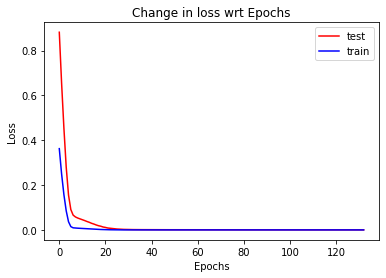

In [ ]:
plt.plot(history.history['val_loss'], color='red', label='test')
plt.plot(history.history['loss'], color='blue', label='train')
plt.title('Change in loss wrt Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pred.shape, Y_test2.shape

((124, 1), (124, 1))

In [ ]:
Y_test2 = np.reshape(Y_test2, (Y_test2.shape[0], 1))
Y_test2.shape

(124, 1)

In [ ]:
Y_test2[:10]

array([[1064.310059],
       [1088.      ],
       [1094.      ],
       [1102.22998 ],
       [1109.400024],
       [1097.099976],
       [1106.300049],
       [1102.410034],
       [1132.51001 ],
       [1126.219971]])

In [ ]:
#For visualization we need all numpy array of same dimension

Y_train = np.reshape(Y_train, (Y_train.shape[0],1))

total_df = total_df.to_numpy()
total_temp = total_df[:,4]   #fetching only new_open column for original dataset
total_temp = np.reshape(total_temp, (total_temp.shape[0], 1))

Y_train.shape, pred.shape, total_temp.shape


((1258, 1), (124, 1), (1382, 1))

In [ ]:
new_np = np.concatenate((Y_train, pred), axis=0)
new_np.shape

(1382, 1)

###Original Dataset Vs Original train + Predicted test



[]

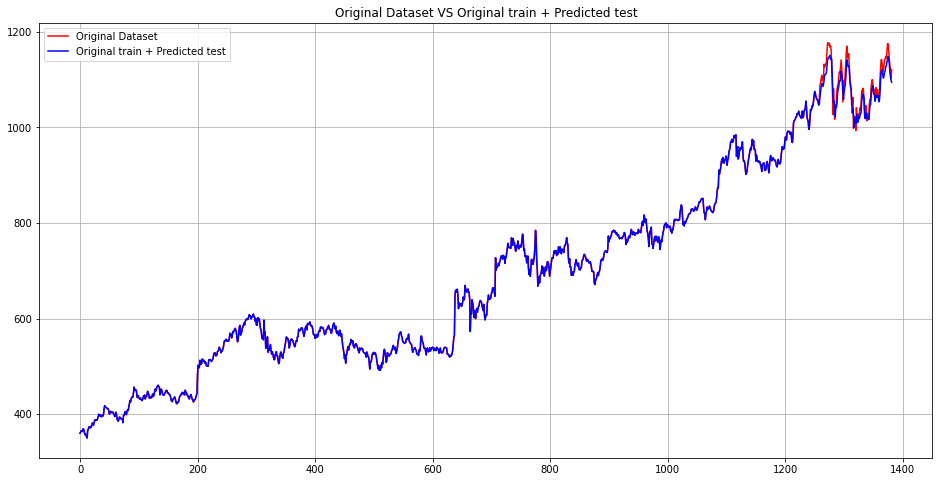

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(total_temp, color='red', label='Original Dataset')
plt.plot(new_np, color='blue',label="Original train + Predicted test" )
plt.title('Original Dataset VS Original train + Predicted test')
plt.legend()
plt.grid(True)
plt.plot()

###Y_test VS Predictions

[]

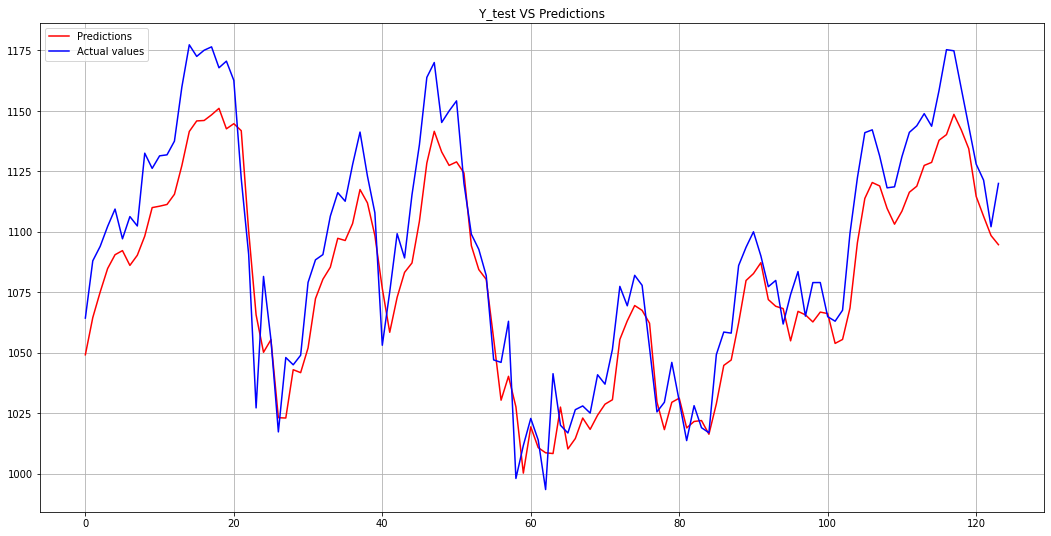

In [ ]:
# A close view of actual and predicted values

plt.figure(figsize=(18,9))
plt.plot(pred, color='red', label='Predictions')
plt.plot(Y_test2, color='blue', label='Actual values')
plt.title('Y_test VS Predictions')
plt.legend()
plt.grid(True)
plt.plot()